Text(0.5, 1.0, 'Time of day signal')

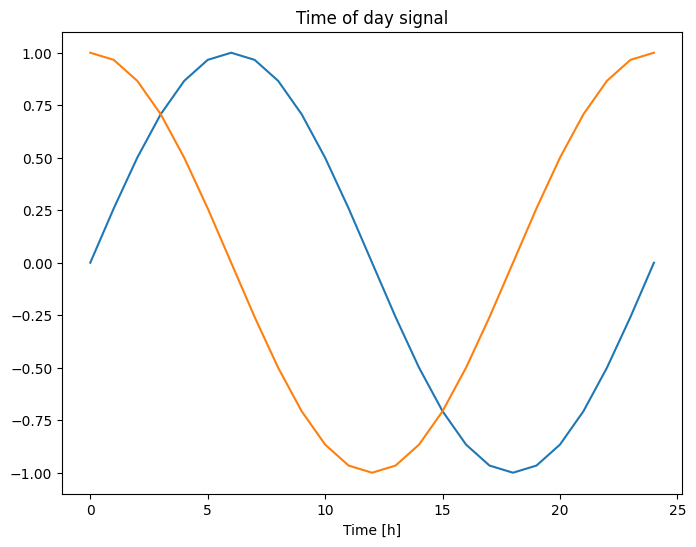

In [11]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

csv_path = 'Tallinn-Harku-2004-2023.csv'
df = pd.read_csv(csv_path)

df['Kell (UTC)'] = df['Kell (UTC)'].str.replace('.', ':')

# Combine 'Aasta', 'Kuu', 'Päev' and 'Kell (UTC)' into a datetime
df['Date Time'] = pd.to_datetime(df['Aasta'].astype(str) + df['Kuu'].astype(str).str.zfill(2) + df['Päev'].astype(str).str.zfill(2) + df['Kell (UTC)'], format='%Y%m%d%H:%M')
date_time = df['Date Time']
# Remove the 'Date Time' column
df = df.drop(['Aasta', 'Kuu', 'Päev', 'Date Time'], axis=1)

df.describe().transpose()


# Wind velocity and direction
wv = df['10 minuti keskmine tuule kiirus m/s']

max_wv = df['Tunni maksimum tuule kiirus m/s']

# The above inplace edits are reflected in the DataFrame.
df['10 minuti keskmine tuule kiirus m/s'].min()

wv = df.pop('10 minuti keskmine tuule kiirus m/s')
max_wv = df.pop('Tunni maksimum tuule kiirus m/s')

# Convert to radians.
wd_rad = df.pop('10 minuti keskmine tuule suund °')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')



In [ ]:
#Which frequencies are important?

fft = tf.signal.rfft(df['Õhutempertuur'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
# Split the data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
# Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
# Plot the data
plot_cols = ['Tunni keskmine summaarne kiirgus W/m²', 'Õhurõhk merepinna kõrgusel hPa', 'Õhurõhk jaama kõrgusel hPa', 'Tunni sademete summa mm', 'Suhteline õhuniiskus %', 'Õhutemperatuur °C', 'Tunni miinimum õhutemperatuur °C', 'Tunni maksimum õhutemperatuur °C', '10 minuti keskmine tuule suund °', '10 minuti keskmine tuule kiirus m/s', 'Tunni maksimum tuule kiirus m/s']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)